# Atlas - Voice Recognition
## Jack Richard
## EECS435 - Deep Learning (Winter 2018-2019)

### Overview
###### The scope of this project is to build a speaker recognition model so that my personal assistant (Atlas) can distinguish commands I make versus commands others make. 
###### This project served as a great learning experience for voice/speaker recognition and the different tools/methodologies that are used to build predictive models. In this project, I leveraged a variety of packages that can be seen below in the imports section.

### 0. Necessary Imports

In [37]:
import numpy as np
from sklearn import preprocessing
import python_speech_features as mfcc
import speech_recognition as SpeechRecognition
import IPython.display as ipd
import librosa
from sklearn.model_selection import train_test_split

import os
import pickle
from scipy.io.wavfile import read
import warnings
warnings.filterwarnings("ignore")
import time

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
SR = 16000

### 1.0 Data Collection
#### For the scope of this project, I wanted to limit the voice recognition to the words I would initially use to active "Atlas", my AI iI have been developing to manage my apartment. So, I gathered a variety of people a had each of them say "Hey Atlas" a handful of times. In addition, I added my own recording to match each iteration they provided, ultimately 60 total audio files.

In [50]:
r = SpeechRecognition.Recognizer()
m = SpeechRecognition.Microphone()
iteration = 1
name = "Jack"

In [51]:
with m as source:
    audio = r.listen(source)
print("Writing to GMM and CNN locations...")
with open("./audio/{0}/{0}-{1}.wav".format(name,iteration), "wb") as f:
    f.write(audio.get_wav_data())
with open("./cnn/data/{0}/{1}.wav".format(name,iteration),"wb") as f:
    f.write(audio.get_wav_data())
iteration += 1

Writing to GMM and CNN locations...


### 2.0 Data Visualization

#### A big hurdle initially was to understand how the audio files are represented, ultimately taking me down a long path towards spectograms, chromagrams, filterbanks, and Mel-Frequency Cepstrum Coefficients (MFCCs). Below are visualizations for a handful of the input files for the signal, the corresponding log_spectogram and the calculated MFCC spectrum.

In [46]:
#Returns Spectogram of Wav Data
def get_spectrogram(wav):
    D = librosa.stft(wav, n_fft=480, hop_length=160,
                     win_length=480, window='hamming')
    spect, phase = librosa.magphase(D)
    return spect
 
#Loads Wav File
def load_wav_file(file_path, plot=True):
    wav, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(wav, sr = SR, n_mfcc=10)
    log_spect = np.log(get_spectrogram(wav))
    if plot:
        plt.imshow(mfcc,cmap='hot', interpolation='nearest')
        plt.show()
    return wav,sr, log_spect, mfcc

#Plotting function for audio files. Plots all files in a given classification 
def plot_waves(category="Jack", mf=False, spect=False):
    num_files = len(os.listdir("./audio/{0}/".format(category)))
    cols = 6
    rows = num_files // cols
    f, axarr = plt.subplots(rows, cols, figsize=(20,20))
    i = 0
    for file in os.listdir("./audio/{0}/".format(category)):
        if "csv" in file or "Jack" in file:
            continue
        row = i // cols
        col = i % cols
        color = "ocean"
        wav, sr,log_spect, mfcc = load_wav_file("./audio/{0}/".format(category) + file, plot=False)
        if mf:
            axarr[row,col].imshow(mfcc,cmap=color, interpolation='nearest')
        elif spect:
            axarr[row,col].imshow(log_spect, aspect='auto', origin='lower')
        else:
            axarr[row,col].plot(wav)
        i+= 1
    plt.show()   

#### 2.1 Spectogram Representation

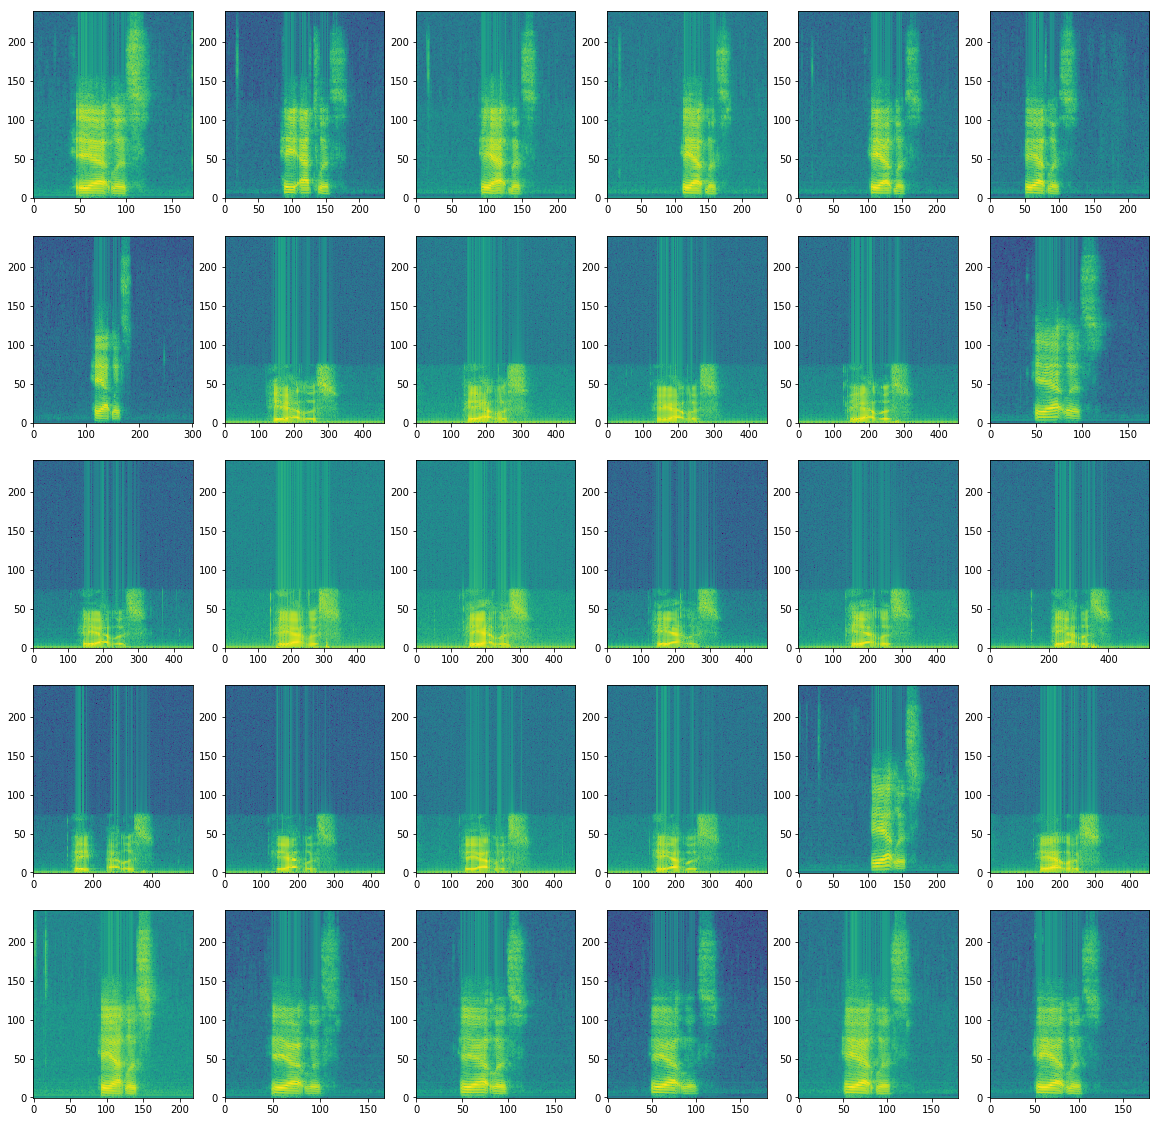

In [47]:
plot_waves(spect=True)

#### 2.2 Mel-frequency cepstral coefficients

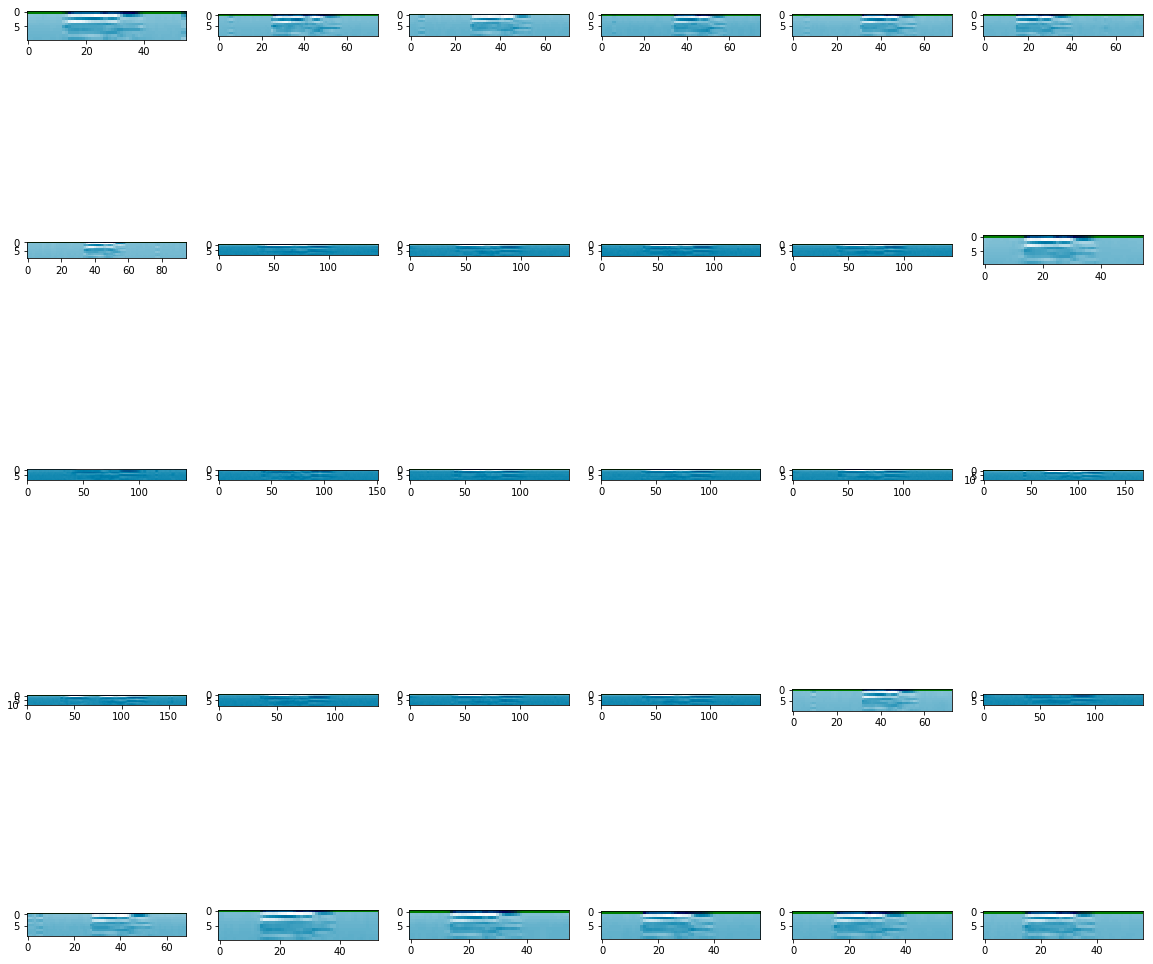

In [48]:
plot_waves(mf=True)

### 3.0 Convolutional Neural Networks

In [ ]:
DATA_PATH = "./cnn/data/"
cnn_path = "./cnn/"

#Takes wav file and returns the resulting padded MFCC array
def wav2mfcc(file_path, max_pad_len=150):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=16000)
    pad_width = max_pad_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc

#Takes all Labels found in the data folder (the subfolder names)
def get_labels(DATA_PATH):
    labels = os.listdir(DATA_PATH)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)

# Returns prediction for wav file
def predict(filepath):
    sample = wav2mfcc(filepath)
    sample_reshaped = sample.reshape(1, 20, MFCC_PADDING, 1)
    print(get_labels(DATA_PATH)[0][np.argmax(model.predict(sample_reshaped))])
    
# Stores list of audio files into a single .npy file
def save_data_to_array(path=DATA_PATH, max_pad_len=150):
    labels, _, _ = get_labels(path)
    for label in labels:
        mfcc_vectors = []
        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in wavfiles:
            mfcc = wav2mfcc(wavfile, max_pad_len=max_pad_len)
            mfcc_vectors.append(mfcc)
        np.save(cnn_path + label + '.npy', mfcc_vectors)

# Splits data into training/testing
def get_train_test(split_ratio=0.8, random_state=42):
    labels, indices, _ = get_labels(DATA_PATH)

    X = np.load(cnn_path + labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    for i, label in enumerate(labels[1:]):
        x = np.load(cnn_path + label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)

#Builds and Trains Model
def get_cnn():
    MFCC_PADDING = 150
    CATEGORIES = 2
    X_train, X_test, y_train, y_test = get_train_test()
    X_train = X_train.reshape(X_train.shape[0], 20, MFCC_PADDING, 1)
    X_test = X_test.reshape(X_test.shape[0], 20, MFCC_PADDING, 1)
    y_train_hot = to_categorical(y_train)
    y_test_hot = to_categorical(y_test)
    keras.backend.clear_session()

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(20, MFCC_PADDING, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(CATEGORIES, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.fit(X_train, y_train_hot, batch_size=100, epochs=200, verbose=1, validation_data=(X_test, y_test_hot))
    return model

#### 3.1 Flaws

##### While Spectograms and MFCCs can be visualized as Images and Convolutional Neural Networks are very effective for training in Image Classification, it doesn't mean it is necessarily applicable to the data. Putting two spectograms next to eachother for two different people saying the same phrase doesn't mean it will be easily distinguishable. Below shows why Sounds and Convolutional Neural Networks don't get along.
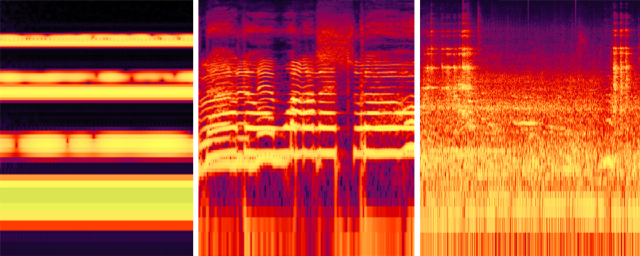

###### (Left): Two similar tones cause uneven phase cancellations across frequencies. (Middle): Two simultaneous voices with similar pitch are difficult to tell apart. (Right): Noisy and complex auditory scenes make it particularly difficult to distinguish sound events.
https://towardsdatascience.com/whats-wrong-with-spectrograms-and-cnns-for-audio-processing-311377d7ccd

### 4.0 Deep Gaussian Mixture Model

##### After many iterations of different modeling approaches, Gaussian Mixture Models saved the day. The implementation below builds a GMM for each speaker during training and stores it in the directory. When predicting the speaker of an audiofile, it ensembles the results of each GMM saved and chooses the best fit model. GMMs act as a clustering algorithm, so this can be seen as minimizing the distance between the prediction result and the input audio file. 

#### 4.1 Feature Extraction

In [27]:
#Frame to Frame Difference
def calculate_delta(array):
    rows,cols = array.shape
    deltas = np.zeros((rows,20))
    N = 2
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i-j < 0:
              first =0
            else:
              first = i-j
            if i+j > rows-1:
                second = rows-1
            else:
                second = i+j 
            index.append((second,first))
            j+=1
        deltas[i] = ( array[index[0][0]]-array[index[0][1]] + (2 * (array[index[1][0]]-array[index[1][1]])) ) / 10
    return deltas

#combines features with deltas of features
def extract_features(audio,rate):
    mfcc_feature = mfcc.mfcc(audio,rate, 0.025, 0.01,20,nfft = 1200, appendEnergy = True)    
    mfcc_feature = preprocessing.scale(mfcc_feature)
    delta = calculate_delta(mfcc_feature)
    combined = np.hstack((mfcc_feature,delta)) 
    return combined

#### 4.2 GMM Training

In [52]:
def build_gmm(filepath):
    gmm_path = "./gmm/"
    features = np.asarray(())
    label = filepath.split("/")[2]
    training_pool = 30
    for i,path in enumerate(sorted(os.listdir(filepath))):
        path = path.strip()       
        # read the audio
        sr,audio = read(filepath + "/" + path)
        # extract 40 dimensional MFCC & delta MFCC features
        vector   = extract_features(audio,sr)
        if features.size == 0:
            features = vector
        else:
            features = np.vstack((features, vector))
        if i == len(os.listdir(filepath)) - 1:    
            gmm = GMM(n_components = 16, max_iter = 200, covariance_type='diag',n_init = 3)
            gmm.fit(features)
            # dumping the trained gaussian model
            picklefile = gmm_path +"models/{0}.gmm".format(label)
            label = 1
            pickle.dump(gmm,open(picklefile,'wb'))
            print('+ modeling completed for speaker:',picklefile," with data point = ",features.shape   )
            features = np.asarray(())
def get_gmm():
    for label in os.listdir("./audio"):
        if "." not in label:
            build_gmm("./audio/"+label)

In [53]:
get_gmm()

+ modeling completed for speaker: ./gmm/models/Jack.gmm  with data point =  (6221, 40)
+ modeling completed for speaker: ./gmm/models/Other.gmm  with data point =  (6372, 40)


#### 4.3 Testing

In [56]:
source   = './gmm/data/'   
modelpath = "./gmm/models/"
gmm_files = [os.path.join(modelpath,fname) for fname in os.listdir(modelpath) if fname.endswith('.gmm')]
models    = [pickle.load(open(fname,'rb')) for fname in gmm_files]
speakers   = [fname.split("/")[-1].split(".gmm")[0] for fname in gmm_files]

In [58]:
error = 0
total_sample = 0.0
print()
take = int(input("Use Input Audio: Press '1' or Run Test: Press '0' ?"))
if take == 1:
    print()
    path = input("Enter the File Name:")
    print("Testing Audio : ", path)    
    sr,audio = read(source + path)
    vector   = extract_features(audio,sr)

    log_likelihood = np.zeros(len(models)) 

    for i in range(len(models)):
        gmm = models[i] 
        scores = np.array(gmm.score(vector))
        log_likelihood[i] = scores.sum()
    
    winner = np.argmax(log_likelihood)
    print("\tdetected as - ", speakers[winner])

    time.sleep(1.0)
elif take == 0:
    test_file = "./gmm/testSamplePath.txt"        
    file_paths = open(test_file,'r')
    for path in file_paths:   
        total_sample += 1.0
        path = path.strip()   
        print("File: ", path)
        sr,audio = read(source + path)
        vector = extract_features(audio,sr)
        log_likelihood = np.zeros(len(models)) 
        for i in range(len(models)):
            gmm = models[i]
            scores = np.array(gmm.score(vector))
            log_likelihood[i] = scores.sum()
    
        winner = np.argmax(log_likelihood)
        print( "\tSpeaker - ", speakers[winner], "\n")
        if ("atlas" in path and speakers[winner] != "Jack") or "atlas" not in path and speakers[winner] == "Jack":
            error += 1
            time.sleep(1.0)
    print("Errors: {0} | Total Samples: {1}".format(error, total_sample))
    accuracy = ((total_sample - error) / total_sample) * 100
    print("Accuracy with MFCC + GMM: ", accuracy, "%")


Use Input Audio: Press '1' or Run Test: Press '0' ?0
File:  atlas-17.wav
	Speaker -  Jack 

File:  atlas-23.wav
	Speaker -  Jack 

File:  atlas-27.wav
	Speaker -  Jack 

File:  atlas-29.wav
	Speaker -  Jack 

File:  noah-4.wav
	Speaker -  Other 

File:  noah-6.wav
	Speaker -  Other 

File:  subrat-2.wav
	Speaker -  Other 

File:  subrat-4.wav
	Speaker -  Other 

File:  vamsi-3.wav
	Speaker -  Other 

File:  vamsi-5.wav
	Speaker -  Other 

Errors: 0 | Total Samples: 10.0
Accuracy with MFCC + GMM:  100.0 %


#### Conclusive Remarks

###### In the future, I plan to collect a much larger number of audio files and for a wide variety of phrases beyond "hey atlas".  In addition, I would like to explore data augmentation to make the Atlas more robust in less friendly settings (locations with a lot of noise). I have also read of the successes using Hidden Markov Models with speaker recognition. Although I have consistently reached 100% accuracy with my test data and a Gaussian Mixture Model Ensemble, it doesn't necessarily mean it will scale. I do, however, like the customizability the ensemble provides. By building models for each inidividual speaker, it means the predictive capabilities of Atlas do not stop with just my voice, but rather anyone I have enough data for. Ultimately I really enjoyed this project and am looking forward to deploying a more robust model to the server.